# PDB File Processing with abagpdb

This notebook demonstrates how to **parse, navigate, and query** protein structures from PDB files using the `abagpdb` package.

## Overview: Hierarchical Data Model

The package uses a hierarchical structure to represent protein complexes:

```
Complex (PDB file)
   ↓
Chains (A, B, C, ...)
   ↓
Residues (amino acids)
   ↓
Atoms (N, CA, C, O, ...)
```

Each level provides methods to access and iterate over its children.

---

## Example: PDB 5GGS
An antibody-antigen complex:
- **Chain H**: Heavy chain (antibody)
- **Chain L**: Light chain (antibody)
- **Chain A**: Antigen protein

## 1. Setup and Imports


In [2]:
import pandas as pd 
import matplotlib.pyplot as plt  

In [3]:
from abagpdb.pdbparser import parse_pdb
from abagpdb.selection import select

In [4]:
def _get(obj, key):
    """Fetch attribute/key from an object, or compute via callable."""
    if callable(key):
        return key(obj)
    # attribute first
    if hasattr(obj, key):
        return getattr(obj, key)
    # then mapping style
    try:
        return obj[key]
    except Exception as e:
        raise AttributeError(f"Cannot access field '{key}' on object of type {type(obj)!r}") from e


def get_dedup_values(list_of_objects, id_property, output_property):
    output = [] 
    ids = [] 
    for obj in list_of_objects:
        id = _get(obj, id_property)
        if id not in ids:
            ids.append(id)
            output.append(_get(obj, output_property))
    return output 

## 2. Parse PDB File

The `parse_pdb()` function reads a PDB file and creates a Complex object. 

In [5]:
# Parse the PDB file
cx = parse_pdb("5GGS_wt.pdb")

print("=" * 60)
print("PDB FILE LOADED SUCCESSFULLY".center(60))
print("=" * 60)
print(f"File path:       {cx.source_path}")
print(f"Total chains:    {len(cx.chains)}")
print(f"Chain IDs:       {', '.join(cx.chains.keys())}")
print("=" * 60)

                PDB FILE LOADED SUCCESSFULLY                
File path:       5GGS_wt.pdb
Total chains:    3
Chain IDs:       A, H, L


### Complex Overview

Get summary statistics about the entire structure.


In [6]:
# Calculate statistics for each chain
print("=" * 70)
print("CHAIN COMPOSITION".center(70))
print("=" * 70)
print(f"{'Chain ID':<12}{'Residues':<15}{'Atoms':<15}{'Description':<25}")
print("-" * 70)

chain_descriptions = {
    'H': 'Heavy chain (Ab)',
    'L': 'Light chain (Ab)',
    'A': 'Antigen'
}

total_residues = 0
total_atoms = 0

for chain_id, chain in cx.chains.items():
    num_residues = len(chain.residues)
    num_atoms = sum(len(res.atoms) for res in chain.residues.values())
    desc = chain_descriptions.get(chain_id, 'Unknown')
    
    total_residues += num_residues
    total_atoms += num_atoms
    
    print(f"{chain_id:<12}{num_residues:<15}{num_atoms:<15}{desc:<25}")

print("-" * 70)
print(f"{'TOTAL':<12}{total_residues:<15}{total_atoms:<15}")
print("=" * 70)

                          CHAIN COMPOSITION                           
Chain ID    Residues       Atoms          Description              
----------------------------------------------------------------------
A           113            890            Antigen                  
H           219            1660           Heavy chain (Ab)         
L           217            1666           Light chain (Ab)         
----------------------------------------------------------------------
TOTAL       549            4216           


### Visualize Chain Sizes


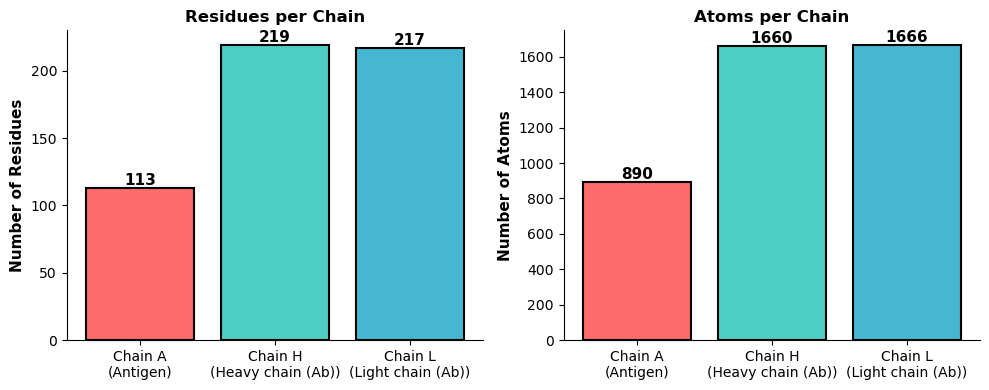

In [9]:
# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Prepare data
chain_ids = list(cx.chains.keys())
residue_counts = [len(cx.chains[cid].residues) for cid in chain_ids]
atom_counts = [sum(len(res.atoms) for res in cx.chains[cid].residues.values()) for cid in chain_ids]

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
labels = [f'Chain {cid}\n({chain_descriptions.get(cid, "Unknown")})' for cid in chain_ids]

# Bar plot for residues
bars1 = ax1.bar(labels, residue_counts, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Number of Residues', fontsize=11, fontweight='bold')
ax1.set_title('Residues per Chain', fontsize=12, fontweight='bold')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Add value labels
for bar, count in zip(bars1, residue_counts):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{count}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Bar plot for atoms
bars2 = ax2.bar(labels, atom_counts, color=colors, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Number of Atoms', fontsize=11, fontweight='bold')
ax2.set_title('Atoms per Chain', fontsize=12, fontweight='bold')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Add value labels
for bar, count in zip(bars2, atom_counts):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{count}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## 3. Named Groups for Regions

You can define **named groups** for specific regions (e.g., CDR loops in antibodies).

In [10]:
# Define CDR regions (Complementarity Determining Regions)
cx.add_group("H:CDR1", "H:26-32")
cx.add_group("H:CDR2", "H:52-56")
cx.add_group("H:CDR3", "H:95-102")
cx.add_group("L:CDR1", "L:24-34")
cx.add_group("L:CDR2", "L:50-56")
cx.add_group("L:CDR3", "L:89-97")

print("✓ Named groups defined successfully!")
print(f"  Total groups: {len(cx._named_groups)}")

✓ Named groups defined successfully!
  Total groups: 6


In [11]:
# Display named groups
print("=" * 50)
print("DEFINED NAMED GROUPS (CDR Regions)".center(50))
print("=" * 50)
print(f"{'Group Name':<15}{'Selection':<20}")
print("-" * 50)

for name, selection in cx._named_groups.items():
    print(f"{name:<15}{selection:<20}")

print("=" * 50)

        DEFINED NAMED GROUPS (CDR Regions)        
Group Name     Selection           
--------------------------------------------------
H:CDR1         H:26-32             
H:CDR2         H:52-56             
H:CDR3         H:95-102            
L:CDR1         L:24-34             
L:CDR2         L:50-56             
L:CDR3         L:89-97             


## 4. Selection System

The **selection system** allows you to extract specific atoms or residues using intuitive syntax.

### Selection Syntax Examples

| Syntax | Description | Example |
|--------|-------------|---------|
| `"H"` | Entire chain | All atoms in chain H |
| `"H:32"` | Single residue | Residue 32 in chain H |
| `"H:26-32"` | Residue range | Residues 26 to 32 in chain H |
| `"H:32.CA"` | Specific atom | CA atom of residue H:32 |
| `"H:CDR1"` | Named group | Predefined region |

In [12]:
# Example 1: Select CDR1 region using named group
cdr1_selection = select(cx, 'H:CDR1')

print("=" * 70)
print("SELECTION EXAMPLE: H:CDR1 (Heavy Chain CDR1)".center(70))
print("=" * 70)
print(f"Selection:        'H:CDR1'")
print(f"Resolves to:      {cx._named_groups['H:CDR1']}")
print(f"Atoms selected:   {len(cdr1_selection.atoms)}")
print("=" * 70)

# Get unique residue information
def get_unique_residues(atoms):
    """Extract unique residues from atom list."""
    seen = set()
    residues = []
    for atom in atoms:
        key = (atom.resseq, atom.resname)
        if key not in seen:
            seen.add(key)
            residues.append(key)
    return residues

unique_res = get_unique_residues(cdr1_selection.atoms)

print("\nResidue Composition:")
print(f"{'Position':<12}{'Residue':<12}{'1-Letter Code':<15}")
print("-" * 70)

# 3-letter to 1-letter code mapping
aa_codes = {
    'ALA': 'A', 'ARG': 'R', 'ASN': 'N', 'ASP': 'D', 'CYS': 'C',
    'GLN': 'Q', 'GLU': 'E', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I',
    'LEU': 'L', 'LYS': 'K', 'MET': 'M', 'PHE': 'F', 'PRO': 'P',
    'SER': 'S', 'THR': 'T', 'TRP': 'W', 'TYR': 'Y', 'VAL': 'V'
}

for resseq, resname in unique_res:
    one_letter = aa_codes.get(resname, '?')
    print(f"H:{resseq:<9}{resname:<12}{one_letter:<15}")

print("=" * 70)
print(f"CDR1 Sequence: {''.join(aa_codes.get(r[1], '?') for r in unique_res)}")
print("=" * 70)

             SELECTION EXAMPLE: H:CDR1 (Heavy Chain CDR1)             
Selection:        'H:CDR1'
Resolves to:      H:26-32
Atoms selected:   69

Residue Composition:
Position    Residue     1-Letter Code  
----------------------------------------------------------------------
H:26       TYR         Y              
H:27       THR         T              
H:28       PHE         F              
H:29       THR         T              
H:30       ASN         N              
H:31       TYR         Y              
H:32       TYR         Y              
CDR1 Sequence: YTFTNYY


## 5. Navigating the Hierarchy

### 5.1 Access Chains

In [13]:
# Access chains from Complex
all_chain_ids = list(cx.chains.keys())

print("Available chains in complex:")
for chain_id in all_chain_ids:
    print(f"  • Chain {chain_id}")

Available chains in complex:
  • Chain A
  • Chain H
  • Chain L


### 5.2 Access Residues in a Chain


In [14]:
# Select chain A (antigen)
chain_A = cx.chains['A']

print("=" * 70)
print(f"CHAIN A: ANTIGEN PROTEIN".center(70))
print("=" * 70)
print(f"Chain ID:         {chain_A.chain_id}")
print(f"Number of residues: {len(chain_A.residues)}")
print("=" * 70)

# Get residue list
residues_A = list(chain_A.residues.values())

print(f"\nFirst 10 residues:")
print(f"{'Position':<12}{'ID String':<20}{'3-Letter':<12}{'1-Letter':<12}{'# Atoms':<10}")
print("-" * 70)

for res in residues_A[:10]:
    one_letter = aa_codes.get(res.resname, '?')
    print(f"{res.resseq:<12}{res.id_str:<20}{res.resname:<12}{one_letter:<12}{len(res.atoms):<10}")

print("=" * 70)

                       CHAIN A: ANTIGEN PROTEIN                       
Chain ID:         A
Number of residues: 113

First 10 residues:
Position    ID String           3-Letter    1-Letter    # Atoms   
----------------------------------------------------------------------
1           PRO A:1             PRO         P           7         
2           TRP A:2             TRP         W           14        
3           ASN A:3             ASN         N           8         
4           PRO A:4             PRO         P           7         
5           PRO A:5             PRO         P           7         
6           THR A:6             THR         T           7         
7           PHE A:7             PHE         F           11        
8           SER A:8             SER         S           6         
9           PRO A:9             PRO         P           7         
10          ALA A:10            ALA         A           5         


### Residue Composition Analysis


In [16]:
# Analyze amino acid composition
from collections import Counter

residue_names = [res.resname for res in residues_A]
residue_counts = Counter(residue_names)

print("=" * 60)
print("AMINO ACID COMPOSITION - CHAIN A".center(60))
print("=" * 60)
print(f"{'Residue':<15}{'3-Letter':<12}{'Count':<10}{'Percentage':<15}")
print("-" * 60)

# Sort by count
sorted_residues = sorted(residue_counts.items(), key=lambda x: x[1], reverse=True)

for resname, count in sorted_residues[:]:   
    one_letter = aa_codes.get(resname, '?')
    percentage = (count / len(residues_A)) * 100
    print(f"{one_letter:<15}{resname:<12}{count:<10}{percentage:<15.1f}%")

print("=" * 60)
print(f"Total unique amino acids: {len(residue_counts)}")
print("=" * 60)

              AMINO ACID COMPOSITION - CHAIN A              
Residue        3-Letter    Count     Percentage     
------------------------------------------------------------
S              SER         13        11.5           %
R              ARG         10        8.8            %
P              PRO         9         8.0            %
A              ALA         9         8.0            %
L              LEU         9         8.0            %
T              THR         8         7.1            %
N              ASN         7         6.2            %
F              PHE         7         6.2            %
V              VAL         6         5.3            %
D              ASP         6         5.3            %
E              GLU         5         4.4            %
G              GLY         5         4.4            %
Q              GLN         5         4.4            %
K              LYS         3         2.7            %
W              TRP         2         1.8            %
C              

### 5.3 Access Atoms in a Residue


In [17]:
# Access a specific residue by key (chain_id, resseq, icode)
residue_sample = chain_A.residues[('A', 4, '')]

print("=" * 90)
print(f"DETAILED VIEW: RESIDUE {residue_sample.id_str}".center(90))
print("=" * 90)
print(f"Residue:      {residue_sample.resname} (Proline)")
print(f"Chain:        {residue_sample.chain_id}")
print(f"Position:     {residue_sample.resseq}")
print(f"Total atoms:  {len(residue_sample.atoms)}")
print("=" * 90)

print("\nAtom Details:")
print(f"{'Atom Name':<12}{'Element':<10}{'Serial':<10}{'X':<12}{'Y':<12}{'Z':<12}{'B-factor':<10}")
print("-" * 90)

for atom in residue_sample.atoms:
    print(f"{atom.name:<12}{atom.element:<10}{atom.serial:<10}"
          f"{atom.x:<12.3f}{atom.y:<12.3f}{atom.z:<12.3f}{atom.bfactor:<10.2f}")

print("=" * 90)

                              DETAILED VIEW: RESIDUE PRO A:4                              
Residue:      PRO (Proline)
Chain:        A
Position:     4
Total atoms:  7

Atom Details:
Atom Name   Element   Serial    X           Y           Z           B-factor  
------------------------------------------------------------------------------------------
N           N         30        34.485      -17.474     -28.539     38.36     
CA          C         31        33.426      -18.450     -28.261     41.38     
C           C         32        33.985      -19.765     -27.726     40.95     
O           O         33        35.114      -20.141     -28.059     37.73     
CB          C         34        32.760      -18.650     -29.627     34.91     
CG          C         35        33.786      -18.241     -30.619     38.09     
CD          C         36        34.585      -17.159     -29.977     40.03     


### 3D Visualization of Atom Positions


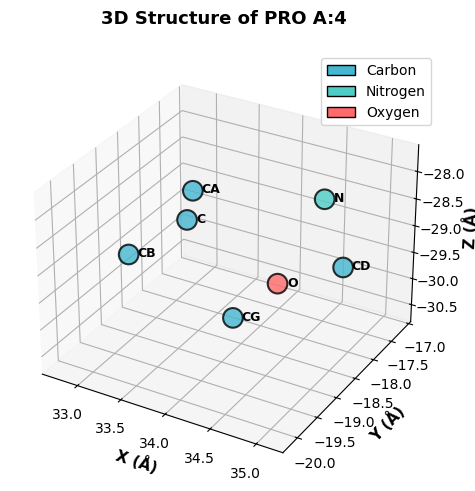

In [23]:
# Visualize the residue's atoms in 3D space
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')

# Extract coordinates
x_coords = [atom.x for atom in residue_sample.atoms]
y_coords = [atom.y for atom in residue_sample.atoms]
z_coords = [atom.z for atom in residue_sample.atoms]
atom_names = [atom.name.strip() for atom in residue_sample.atoms]

# Color by atom type
colors = []
for atom in residue_sample.atoms:
    if atom.element == 'C':
        colors.append('#45B7D1')
    elif atom.element == 'N':
        colors.append('#4ECDC4')
    elif atom.element == 'O':
        colors.append('#FF6B6B')
    else:
        colors.append('#95A5A6')

# Plot atoms
scatter = ax.scatter(x_coords, y_coords, z_coords, c=colors, s=200, 
                     edgecolors='black', linewidths=1.5, alpha=0.8)

# Label atoms
for i, name in enumerate(atom_names):
    ax.text(x_coords[i]+0.1, y_coords[i], z_coords[i], name, 
            fontsize=9, fontweight='bold')

ax.set_xlabel('X (Å)', fontweight='bold', fontsize=11)
ax.set_ylabel('Y (Å)', fontweight='bold', fontsize=11)
ax.set_zlabel('Z (Å)', fontweight='bold', fontsize=11)
ax.set_title(f'3D Structure of {residue_sample.id_str}', 
             fontweight='bold', fontsize=13, pad=20)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#45B7D1', edgecolor='black', label='Carbon'),
    Patch(facecolor='#4ECDC4', edgecolor='black', label='Nitrogen'),
    Patch(facecolor='#FF6B6B', edgecolor='black', label='Oxygen')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

## 6. Advanced Selection Examples

Demonstrate various selection patterns.

In [24]:
# Examples of different selection patterns
examples = [
    ("Entire chain H", "H"),
    ("Single residue", "H:32"),
    ("Residue range", "H:30-35"),
    ("Specific atom", "H:32.CA"),
    ("Named group", "H:CDR1"),
    ("Multiple chains", ["H", "L"])
]

print("=" * 80)
print("SELECTION EXAMPLES".center(80))
print("=" * 80)
print(f"{'Description':<25}{'Selection':<25}{'Atoms Selected':<15}{'Residues':<15}")
print("-" * 80)

for desc, sel in examples:
    selection = select(cx, sel)
    num_atoms = len(selection.atoms)
    
    # Count unique residues
    unique_residues = len(set((a.chain_id, a.resseq, a.icode) for a in selection.atoms))
    
    sel_str = str(sel) if not isinstance(sel, list) else ", ".join(sel)
    print(f"{desc:<25}{sel_str:<25}{num_atoms:<15}{unique_residues:<15}")

print("=" * 80)

                               SELECTION EXAMPLES                               
Description              Selection                Atoms Selected Residues       
--------------------------------------------------------------------------------
Entire chain H           H                        1660           219            
Single residue           H:32                     12             1              
Residue range            H:30-35                  66             6              
Specific atom            H:32.CA                  1              1              
Named group              H:CDR1                   69             7              
Multiple chains          H, L                     3326           436            


## 7. Iterating Over Structure

Demonstrate how to iterate through the hierarchy.

In [25]:
# Example: Count CA atoms in each chain
print("=" * 60)
print("CA ATOM COUNT PER CHAIN".center(60))
print("=" * 60)
print(f"{'Chain':<15}{'CA Atoms':<15}{'Total Atoms':<15}{'CA %':<15}")
print("-" * 60)

for chain_id, chain in cx.chains.items():
    ca_count = 0
    total_atoms = 0
    
    # Iterate over residues in chain
    for residue in chain.iter_residues():
        # Iterate over atoms in residue
        for atom in residue.atoms:
            total_atoms += 1
            if atom.name.strip() == 'CA':
                ca_count += 1
    
    ca_percentage = (ca_count / total_atoms * 100) if total_atoms > 0 else 0
    print(f"{chain_id:<15}{ca_count:<15}{total_atoms:<15}{ca_percentage:<15.1f}%")

print("=" * 60)

                  CA ATOM COUNT PER CHAIN                   
Chain          CA Atoms       Total Atoms    CA %           
------------------------------------------------------------
A              113            890            12.7           %
H              219            1660           13.2           %
L              217            1666           13.0           %


## 8. Data Extraction to DataFrame

Convert structure data to pandas DataFrame for analysis.

In [26]:
# Create DataFrame of all atoms
atom_data = []

for chain_id, chain in cx.chains.items():
    for residue in chain.iter_residues():
        for atom in residue.atoms:
            atom_data.append({
                'chain': chain_id,
                'residue_name': residue.resname,
                'residue_num': residue.resseq,
                'atom_name': atom.name.strip(),
                'element': atom.element,
                'x': atom.x,
                'y': atom.y,
                'z': atom.z,
                'bfactor': atom.bfactor
            })

df_atoms = pd.DataFrame(atom_data)

print(f"DataFrame created with {len(df_atoms)} atoms")
print(f"\nColumns: {list(df_atoms.columns)}")
print(f"\nFirst 10 rows:")
df_atoms.head(10)

DataFrame created with 4216 atoms

Columns: ['chain', 'residue_name', 'residue_num', 'atom_name', 'element', 'x', 'y', 'z', 'bfactor']

First 10 rows:


,chain,residue_name,residue_num,atom_name,element,x,y,z,bfactor
0,A,PRO,1,N,N,39.717,-10.248,-23.776,69.05
1,A,PRO,1,CA,C,38.342,-10.712,-23.983,57.25
2,A,PRO,1,C,C,37.912,-10.680,-25.453,57.04
3,A,PRO,1,O,O,38.303,-9.709,-26.110,61.89
4,A,PRO,1,CB,C,37.502,-9.712,-23.168,55.10
5,A,PRO,1,CG,C,38.465,-8.587,-22.750,60.28
6,A,PRO,1,CD,C,39.771,-8.819,-23.437,63.90
7,A,TRP,2,N,N,37.187,-11.669,-25.996,54.28
8,A,TRP,2,CA,C,37.025,-13.057,-25.526,50.52
9,A,TRP,2,C,C,36.468,-13.857,-26.707,48.70


### B-factor Distribution Analysis


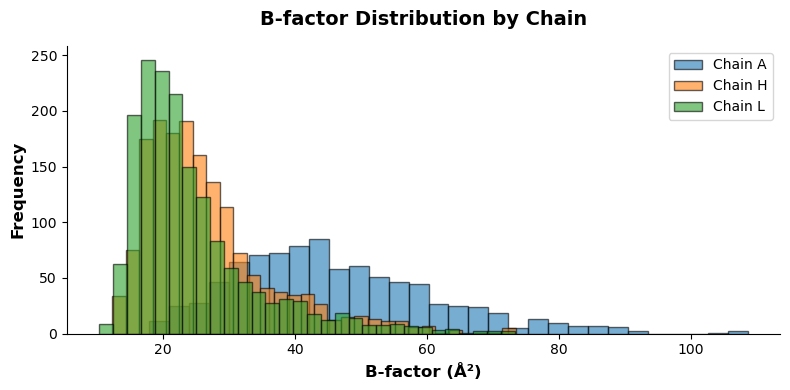


B-factor Statistics by Chain:
            mean        std    min     max
chain                                     
A      46.288101  15.199060  17.90  108.60
H      26.764271   9.936109  12.26   73.46
L      24.443439   9.834692  10.31   73.28


In [28]:
# Analyze B-factors by chain
fig, ax = plt.subplots(figsize=(8, 4))

for chain_id in df_atoms['chain'].unique():
    chain_data = df_atoms[df_atoms['chain'] == chain_id]
    ax.hist(chain_data['bfactor'], bins=30, alpha=0.6, 
            label=f'Chain {chain_id}', edgecolor='black')

ax.set_xlabel('B-factor (Å²)', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('B-factor Distribution by Chain', fontsize=14, fontweight='bold', pad=15)
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Summary statistics
print("\nB-factor Statistics by Chain:")
print(df_atoms.groupby('chain')['bfactor'].describe()[['mean', 'std', 'min', 'max']])

## 9. Key Concepts Summary


In [29]:
print("=" * 80)
print("KEY CONCEPTS: PDB HANDLING WITH ABAGPDB".center(80))
print("=" * 80)

print("\n📁 File Parsing:")
print("   • parse_pdb('file.pdb') → Complex object")
print("   • Handles altloc, HETATM, and multiple chains")

print("\n🔗 Hierarchical Structure:")
print("   • Complex → Chains → Residues → Atoms")
print("   • Each level accessible via .chains, .residues, .atoms")

print("\n🎯 Selection System:")
print("   • Chain:        select(cx, 'H')")
print("   • Residue:      select(cx, 'H:32')")
print("   • Range:        select(cx, 'H:30-35')")
print("   • Atom:         select(cx, 'H:32.CA')")
print("   • Named group:  select(cx, 'H:CDR1')")
print("   • Multiple:     select(cx, ['H', 'L'])")

print("\n📊 Data Access:")
print("   • cx.chains['A']                  → Access specific chain")
print("   • chain.residues[(chain,seq,ic)]  → Access specific residue")
print("   • residue.atoms                   → Get all atoms")
print("   • atom.coord                      → Get (x,y,z) coordinates")

print("\n🔄 Iteration:")
print("   • chain.iter_residues()           → Iterate over residues")
print("   • residue.iter_atoms(ignore_h=T)  → Iterate over atoms")

print("\n🏷️ Named Groups:")
print("   • cx.add_group('name', 'H:30-35') → Define custom regions")
print("   • Useful for CDRs, domains, motifs")

print("\n" + "=" * 80)

                    KEY CONCEPTS: PDB HANDLING WITH ABAGPDB                     

📁 File Parsing:
   • parse_pdb('file.pdb') → Complex object
   • Handles altloc, HETATM, and multiple chains

🔗 Hierarchical Structure:
   • Complex → Chains → Residues → Atoms
   • Each level accessible via .chains, .residues, .atoms

🎯 Selection System:
   • Chain:        select(cx, 'H')
   • Residue:      select(cx, 'H:32')
   • Range:        select(cx, 'H:30-35')
   • Atom:         select(cx, 'H:32.CA')
   • Named group:  select(cx, 'H:CDR1')
   • Multiple:     select(cx, ['H', 'L'])

📊 Data Access:
   • cx.chains['A']                  → Access specific chain
   • chain.residues[(chain,seq,ic)]  → Access specific residue
   • residue.atoms                   → Get all atoms
   • atom.coord                      → Get (x,y,z) coordinates

🔄 Iteration:
   • chain.iter_residues()           → Iterate over residues
   • residue.iter_atoms(ignore_h=T)  → Iterate over atoms

🏷️ Named Groups:
   • cx.add_group(

## End